### task 1

# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет. 

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

In [111]:
df = pd.read_csv('./data/persons_pics_train.csv')
# df.head()

Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [112]:
def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

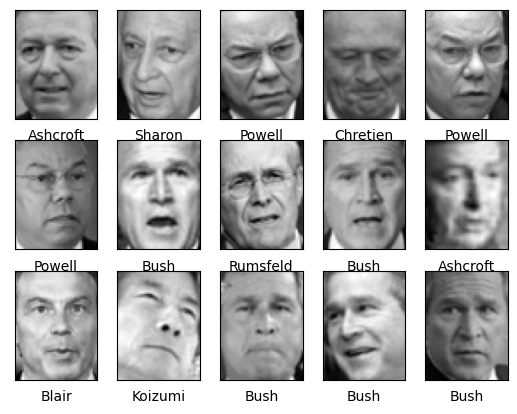

In [113]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])
plt.savefig('persons_pics_img_for_description.png', dpi = 300, bbox_inches='tight')    

Крупнее

(-0.5, 46.5, 61.5, -0.5)

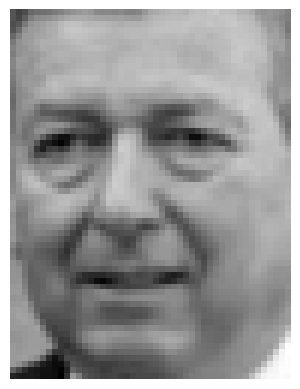

In [114]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [115]:
len(df['label'].unique())

12

Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса. 

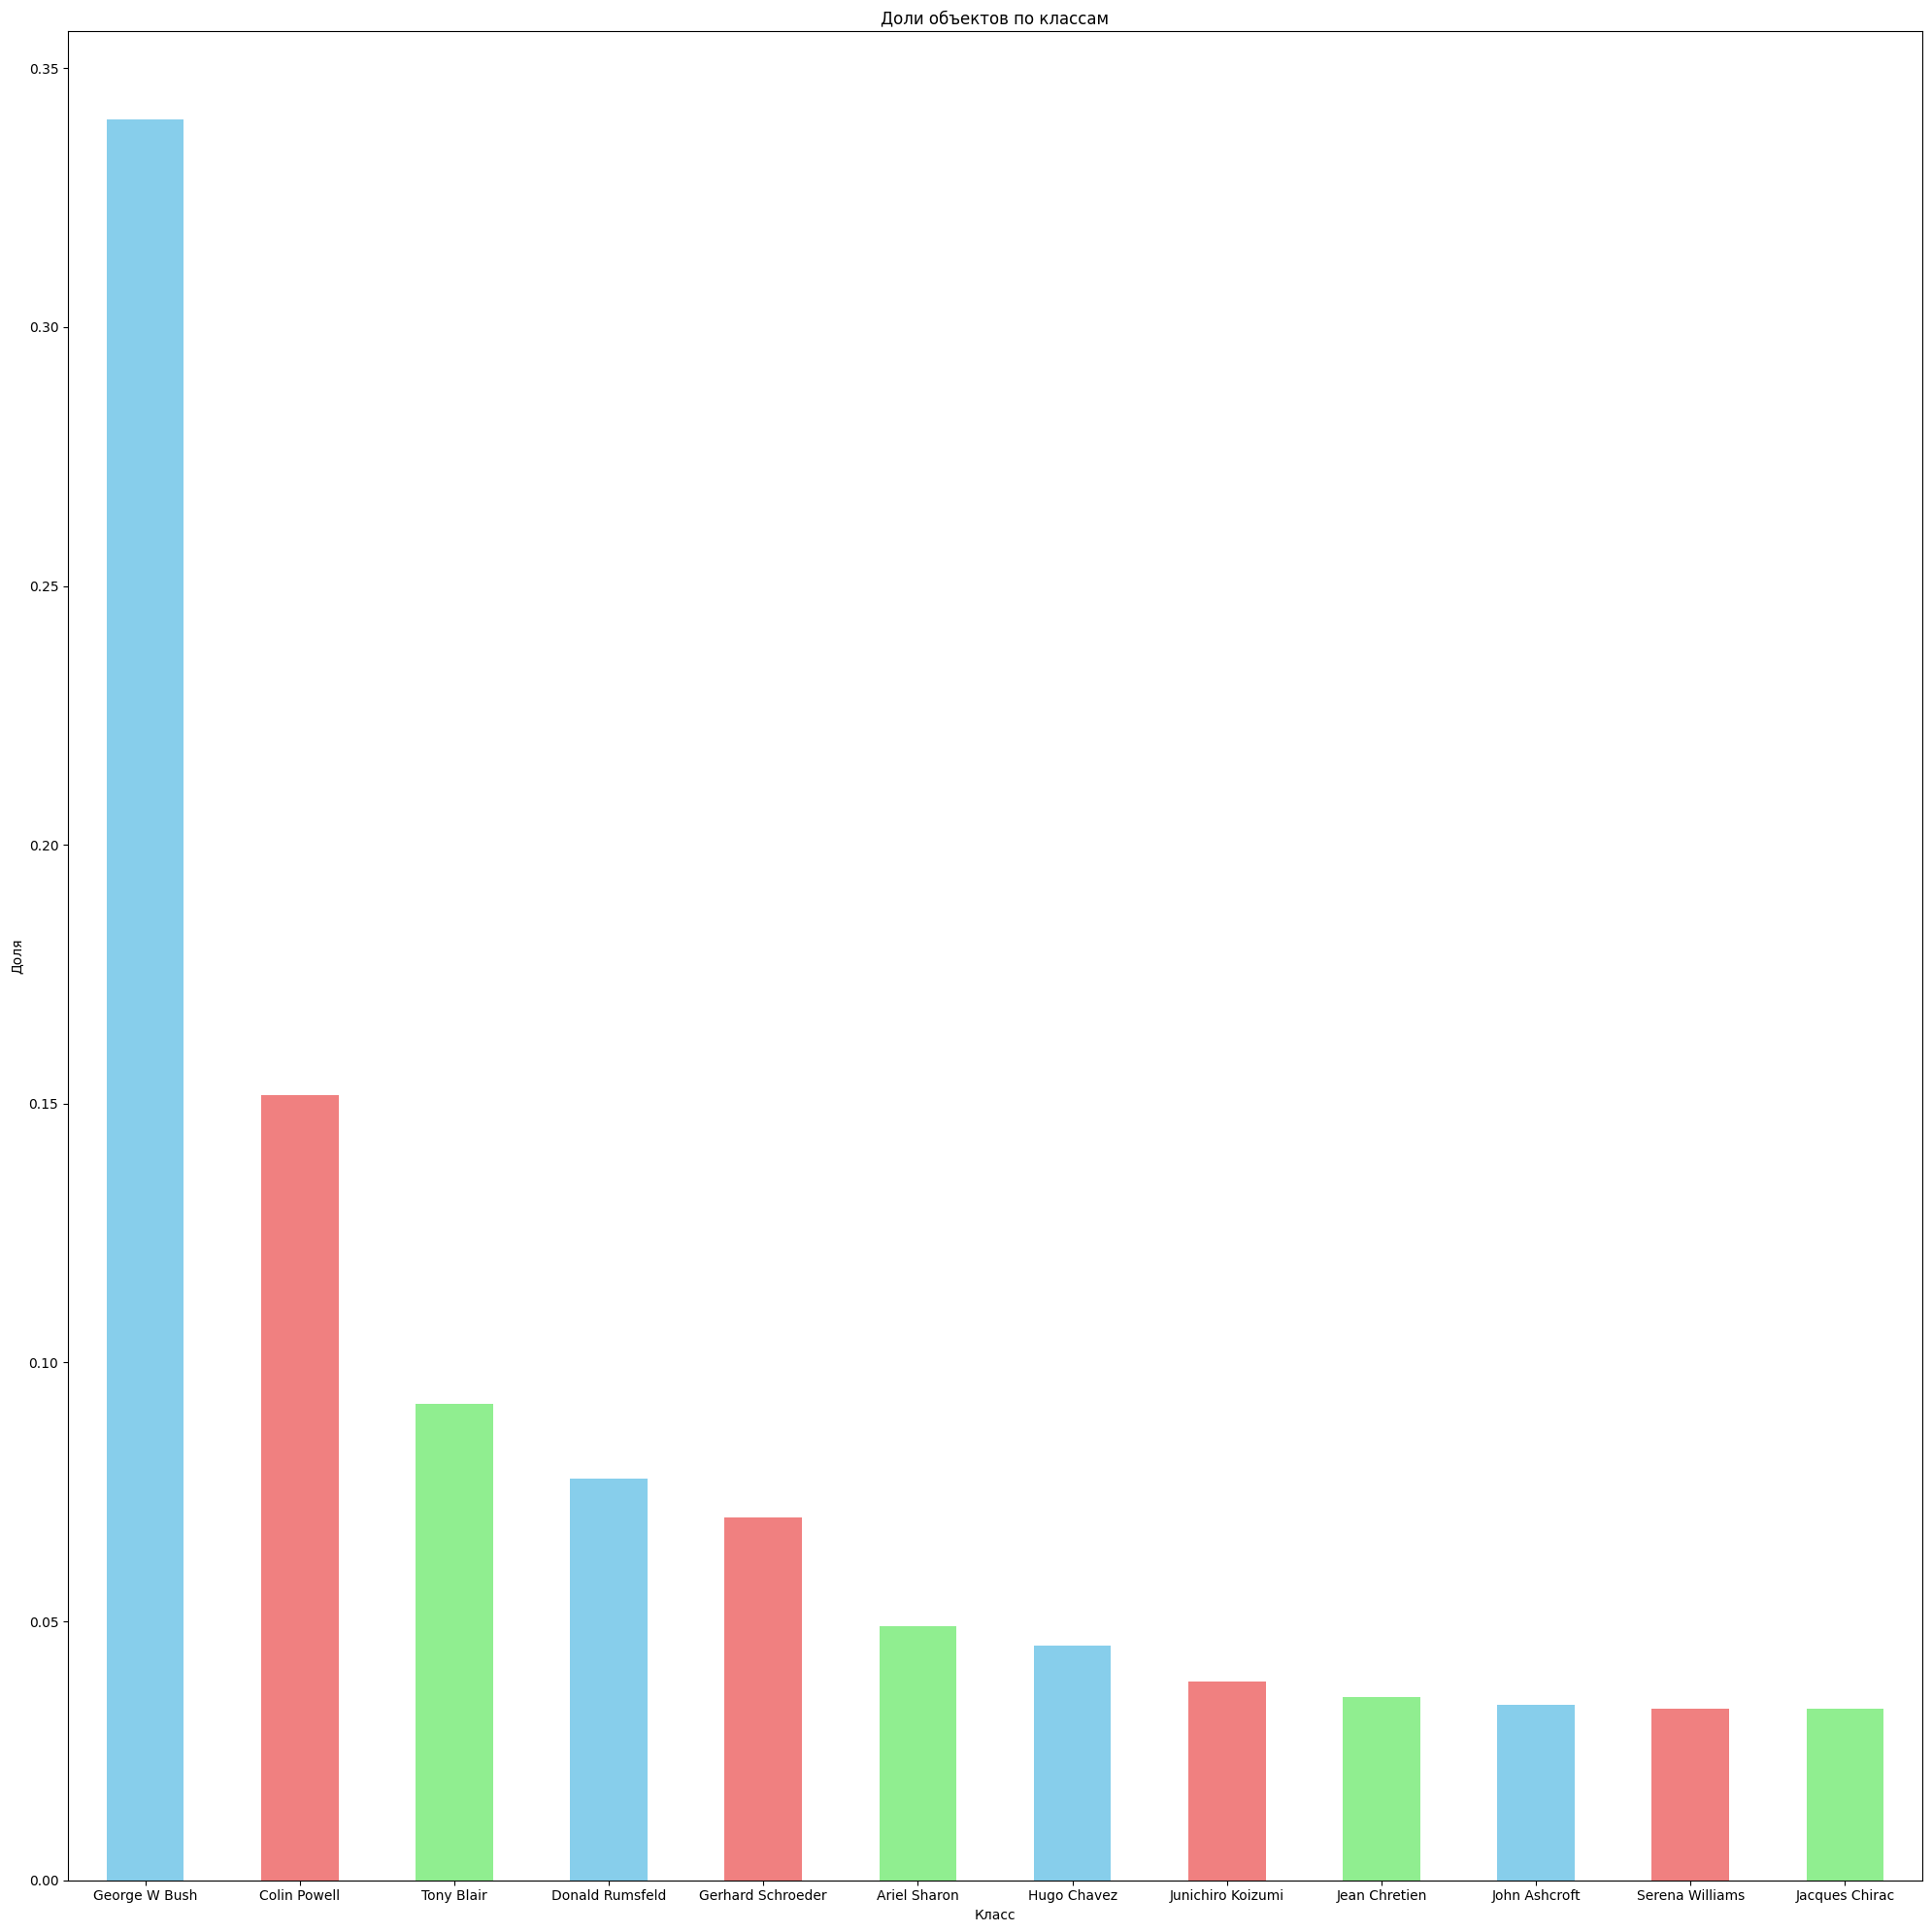

In [116]:
label_distribution = df['label'].value_counts()
label_proportions = df['label'].value_counts(normalize = True)

plt.figure(figsize=(20, 20))
label_proportions.plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Доли объектов по классам')
plt.xlabel('Класс')
plt.ylabel('Доля')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [117]:
label_proportions

label
George W Bush        0.340121
Colin Powell         0.151584
Tony Blair           0.092006
Donald Rumsfeld      0.077677
Gerhard Schroeder    0.070136
Ariel Sharon         0.049020
Hugo Chavez          0.045249
Junichiro Koizumi    0.038462
Jean Chretien        0.035445
John Ashcroft        0.033937
Serena Williams      0.033183
Jacques Chirac       0.033183
Name: proportion, dtype: float64

In [118]:
f"{label_proportions['Donald Rumsfeld']:.3f}"

'0.078'

На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [119]:
columns_to_average = df.columns.drop('label')
mean_vectors_df = df.groupby(by='label')[columns_to_average].aggregate('mean').reset_index()
mean_vectors_df.head()

,label,0,1,2,3,4,5,6,7,8,...,2904,2905,2906,2907,2908,2909,2910,2911,2912,2913
0,Ariel Sharon,0.501398,0.514811,0.532609,0.551714,0.569754,0.577456,0.581820,0.591835,0.604465,...,0.396400,0.433947,0.478291,0.519920,0.532549,0.515656,0.498220,0.486657,0.466928,0.437687
1,Colin Powell,0.433512,0.441147,0.456248,0.471947,0.486730,0.513732,0.545157,0.566514,0.581556,...,0.437869,0.471798,0.512067,0.534615,0.532176,0.510006,0.477586,0.448119,0.410659,0.379605
2,Donald Rumsfeld,0.404810,0.417260,0.442731,0.474028,0.507938,0.541659,0.560112,0.571838,0.585773,...,0.494917,0.546837,0.562307,0.558627,0.549426,0.525947,0.500603,0.475550,0.431893,0.391738
3,George W Bush,0.348179,0.360263,0.381659,0.416669,0.457154,0.488335,0.515398,0.536075,0.551153,...,0.385818,0.414092,0.441074,0.461325,0.470275,0.459067,0.447653,0.430523,0.399620,0.376584
4,Gerhard Schroeder,0.210162,0.228210,0.268255,0.328344,0.389332,0.447115,0.495003,0.527655,0.549441,...,0.414969,0.430937,0.469281,0.494596,0.496718,0.482550,0.442252,0.428477,0.426875,0.411118


Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [120]:
f"{mean_vectors_df[mean_vectors_df['label'] == 'George W Bush']['0'].iloc[0]:.3f}"

'0.348'

Используя усредненные векторы, постройте изображения всех людей из набора данных.

In [121]:
def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

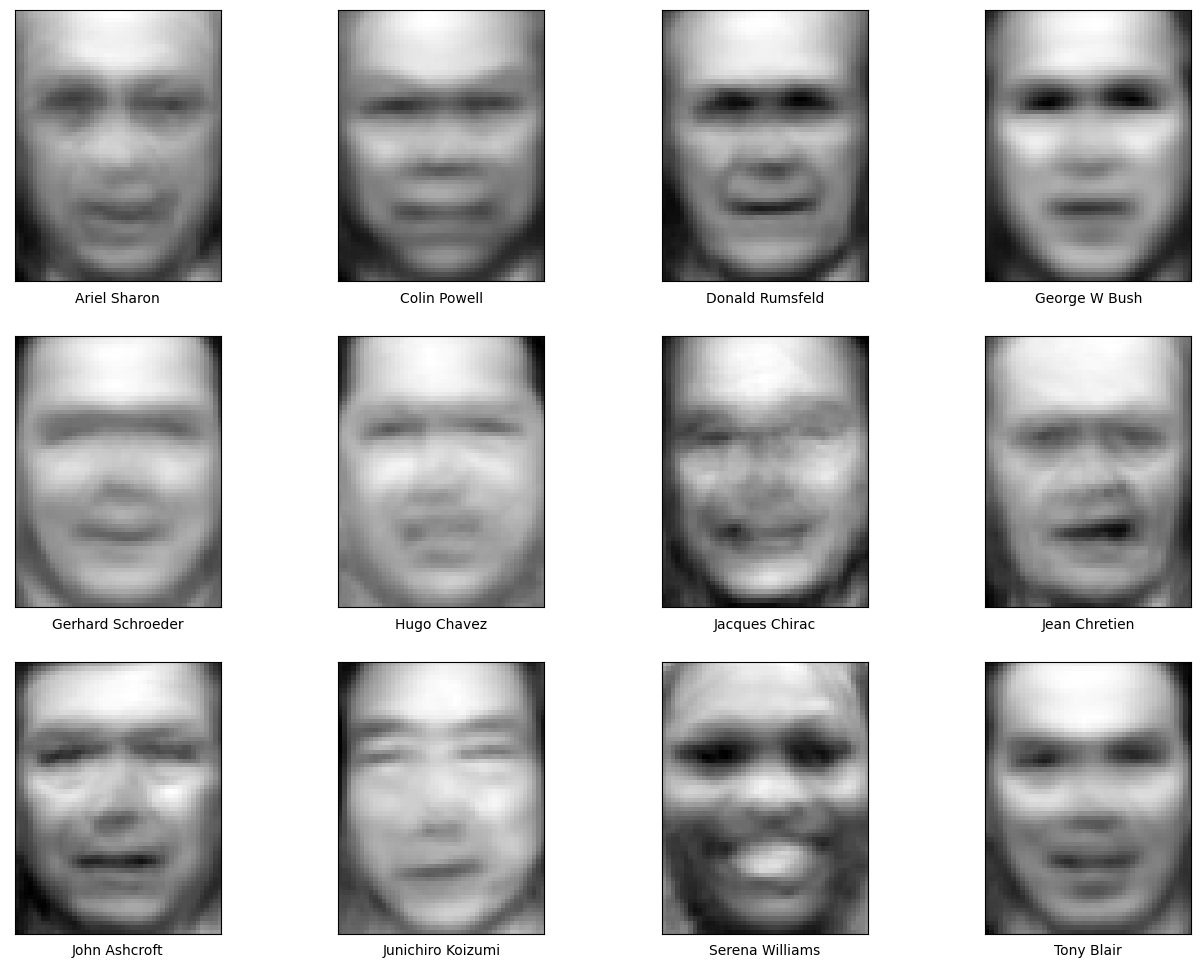

In [122]:
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(mean_vectors_df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl)
plt.savefig('persons_pics_img_for_description_avg.png', dpi = 300, bbox_inches='tight')    

Gehard Schroeder

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

In [123]:
from sklearn.metrics.pairwise import cosine_similarity

labels = mean_vectors_df['label']

vals = mean_vectors_df.drop(columns='label').values
mtx = cosine_similarity(vals)

mtx

array([[1.        , 0.99785382, 0.99675206, 0.99481363, 0.99341471,
        0.98961168, 0.99317214, 0.99597735, 0.99513093, 0.9878161 ,
        0.98777385, 0.99536216],
       [0.99785382, 1.        , 0.99769996, 0.99640904, 0.99546998,
        0.99277575, 0.99513082, 0.99649017, 0.99629515, 0.99040867,
        0.98836968, 0.99736715],
       [0.99675206, 0.99769996, 1.        , 0.99664513, 0.99630905,
        0.99195352, 0.99515232, 0.99744815, 0.99530811, 0.98858437,
        0.98660566, 0.99729159],
       [0.99481363, 0.99640904, 0.99664513, 1.        , 0.99772842,
        0.99635287, 0.99622325, 0.99351621, 0.99746496, 0.99366745,
        0.98530697, 0.99733115],
       [0.99341471, 0.99546998, 0.99630905, 0.99772842, 1.        ,
        0.997621  , 0.99722896, 0.99411832, 0.99698581, 0.99377415,
        0.98574773, 0.99810676],
       [0.98961168, 0.99277575, 0.99195352, 0.99635287, 0.997621  ,
        1.        , 0.99518468, 0.98989008, 0.99479407, 0.99382846,
        0.9832438 ,

Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [124]:
labels

0          Ariel Sharon
1          Colin Powell
2       Donald Rumsfeld
3         George W Bush
4     Gerhard Schroeder
5           Hugo Chavez
6        Jacques Chirac
7         Jean Chretien
8         John Ashcroft
9     Junichiro Koizumi
10      Serena Williams
11           Tony Blair
Name: label, dtype: object

In [125]:
# Jacques Chirac и Serena Williams
i = labels[labels == 'Jacques Chirac'].index[0]
j = labels[labels == 'Serena Williams'].index[0]
f"{mtx[j, i]:.3f}"

'0.983'

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [126]:
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2, 
                                                    random_state = 55,
                                                    stratify = y)

## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [ ]:
svc = SVC(kernel='linear', random_state=55)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
f"{f1_score(y_test, y_pred, average = 'weighted'):.3f}"

'0.821'

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [ ]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced'], 'random_state':[55]}]
    
cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
cv.fit(X_train, y_train)
cv.best_params_

Определите гиперпараметры лучшей полученной модели.

In [133]:
y_pred = cv.predict(X_test)

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [134]:
f"{f1_score(y_test, y_pred, average='weighted'):.3f}"

'0.808'

## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [137]:
l = 0
r = min(2914, len(X_train)) + 1

while (r - l > 1):
    m = (r + l) // 2
    pca = PCA(n_components = m, svd_solver='full')
    pca.fit(X_train)
    e = sum(pca.explained_variance_ratio_)

    if (e >= 0.95): 
        r = m
    else: 
        l = m

m

172

Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [138]:
pca = PCA(n_components = m, svd_solver='full')
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [ ]:
cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)
cv.fit(X_train, y_train)

Определите гиперпараметры лучшей полученной модели.

In [140]:
cv.best_params_

{'C': 100,
 'class_weight': 'balanced',
 'gamma': 0.001,
 'kernel': 'rbf',
 'random_state': 55}

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [141]:
y_pred = cv.predict(X_test)
f"{f1_score(y_test, y_pred, average='weighted'):.3f}"

'0.809'

Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.

### task 2

In [164]:
df_train = pd.read_csv("./data/persons_pics_train.csv")
df_test = pd.read_csv("./data/persons_pics_reserved.csv")

In [165]:
X_train = df_train.drop('label', axis=1)
y_train = df_train['label']

X_test = df_test

In [166]:
tuned_parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000], 'class_weight': [None, 'balanced']}]
cv = GridSearchCV(SVC(), tuned_parameters, refit=True, verbose=3)

In [167]:
cv.fit(X_train, y_train)
cv.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=linear;, score=0.805 total time=   1.5s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=linear;, score=0.808 total time=   1.6s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=linear;, score=0.808 total time=   1.6s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=linear;, score=0.789 total time=   1.4s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=linear;, score=0.796 total time=   1.5s
[CV 1/5] END C=1, class_weight=None, gamma=0.001, kernel=poly;, score=0.395 total time=   2.1s
[CV 2/5] END C=1, class_weight=None, gamma=0.001, kernel=poly;, score=0.385 total time=   2.0s
[CV 3/5] END C=1, class_weight=None, gamma=0.001, kernel=poly;, score=0.370 total time=   2.1s
[CV 4/5] END C=1, class_weight=None, gamma=0.001, kernel=poly;, score=0.396 total time=   2.1s
[CV 5/5] END C=1, class_weight=None, gamma=0.001, kernel=poly;, score=0.3

{'C': 1000, 'class_weight': None, 'gamma': 0.001, 'kernel': 'rbf'}

In [168]:
print(', '.join(map(lambda x: f"'{x}'", y_pred)))

'George W Bush', 'Ariel Sharon', 'Jacques Chirac', 'Jacques Chirac', 'Tony Blair', 'Colin Powell', 'Donald Rumsfeld', 'Colin Powell', 'Tony Blair', 'George W Bush', 'Donald Rumsfeld', 'Hugo Chavez', 'George W Bush', 'Hugo Chavez', 'Colin Powell', 'George W Bush', 'Ariel Sharon', 'Colin Powell', 'John Ashcroft', 'Gerhard Schroeder', 'Ariel Sharon', 'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush', 'Donald Rumsfeld', 'Donald Rumsfeld', 'Tony Blair', 'Serena Williams', 'Jean Chretien', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'Colin Powell', 'Donald Rumsfeld', 'Jacques Chirac', 'George W Bush', 'Gerhard Schroeder', 'Colin Powell', 'Donald Rumsfeld', 'Gerhard Schroeder', 'George W Bush', 'Tony Blair', 'George W Bush', 'George W Bush', 'Tony Blair', 'Colin Powell', 'Tony Blair', 'Serena Williams', 'Jean Chretien', 'Tony Blair', 'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'Ge

In [163]:
svc = SVC(kernel='linear', gamma = 1e-3, C = 1, class_weight = None, probability = True)
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)
print(', '.join(map(lambda x: f"'{x}'", y_pred)))

'George W Bush', 'Ariel Sharon', 'Jacques Chirac', 'Jacques Chirac', 'Tony Blair', 'Colin Powell', 'Donald Rumsfeld', 'Colin Powell', 'Tony Blair', 'George W Bush', 'Donald Rumsfeld', 'Hugo Chavez', 'George W Bush', 'Hugo Chavez', 'Colin Powell', 'George W Bush', 'Ariel Sharon', 'Colin Powell', 'John Ashcroft', 'Gerhard Schroeder', 'Ariel Sharon', 'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush', 'Donald Rumsfeld', 'Donald Rumsfeld', 'Tony Blair', 'Serena Williams', 'Jean Chretien', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'Colin Powell', 'Donald Rumsfeld', 'Jacques Chirac', 'George W Bush', 'Gerhard Schroeder', 'Colin Powell', 'Donald Rumsfeld', 'Gerhard Schroeder', 'George W Bush', 'Tony Blair', 'George W Bush', 'George W Bush', 'Tony Blair', 'Colin Powell', 'Tony Blair', 'Serena Williams', 'Jean Chretien', 'Tony Blair', 'George W Bush', 'Colin Powell', 'George W Bush', 'George W Bush', 'George W Bush', 'George W Bush', 'Ge